In [1]:
import numpy as np 
import corner as DFM

from astroML.density_estimation import XDGMM
from sklearn.mixture import GaussianMixture as GMix
from extreme_deconvolution import extreme_deconvolution
from scipy.stats import multivariate_normal as MNorm

import env
import catalogs as Cats
from fstarforms import fstarforms
from fstarforms import xdGMM

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
Cat = Cats.Catalog()
_logM, _logSFR, w, censat = Cat.Read('illustris_100myr')
iscen = (censat == 1)
logM = _logM[iscen]
logSFR = _logSFR[iscen]

logSFR_err = 0.434*(2.e-2)/(10.**logSFR)

/Users/chang/projects/LetsTalkAboutQuench/letstalkaboutquench/catalogs.py:71: RuntimeWarning: divide by zero encountered in log10
  logSFR = np.log10(_ssfr) + logM # calculate log SFR from sSFR

------ illustris_100myr ------
16943 of 66808 galaxies have 0/non-finite SFRs
logSFR of these galaxies will be -999.
/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys


In [4]:
mlim = (logM > 10.0) & (logM < 10.2) & (np.isfinite(logSFR_err))

(-2.5, 0.75)

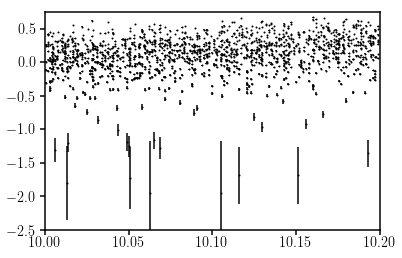

In [5]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.errorbar(logM[mlim], logSFR[mlim], yerr=logSFR_err[mlim], fmt='.k', markersize=2)
sub.set_xlim([10., 10.2])
sub.set_ylim([-2.5, 0.75])

In [6]:
xdgmm = XDGMM(3, n_iter=500)

In [8]:
X = np.reshape((logSFR[mlim] - logM[mlim]), (-1, 1))
Xerr = np.reshape(logSFR_err[mlim], (-1,1,1))
xdgmm.fit(X, Xerr)

/Users/chang/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/chang/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/chang/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/chang/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecatio

(-13.0, -9)

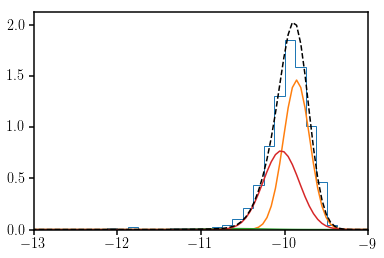

In [9]:
xx = np.linspace(-14., -9., 100)
fig = plt.figure()
sub = fig.add_subplot(111)
_ = sub.hist(logSFR[mlim] - logM[mlim], normed=True, histtype='step', range=[-13., -9], bins=32)
for icomp in range(len(xdgmm.mu)): 
    sub.plot(xx, xdgmm.alpha[icomp]*MNorm.pdf(xx, xdgmm.mu[icomp], xdgmm.V[icomp]))
    if icomp == 0: 
        gtot = xdgmm.alpha[icomp]*MNorm.pdf(xx, xdgmm.mu[icomp], xdgmm.V[icomp])
    else: 
        gtot += xdgmm.alpha[icomp]*MNorm.pdf(xx, xdgmm.mu[icomp], xdgmm.V[icomp])
sub.plot(xx, gtot, c='k', ls='--')
sub.set_xlim([-13., -9])

In [26]:
print np.sum(xdgmm.logprob_a(X, Xerr), axis=1)[:10]
print xdgmm.logL(X, Xerr)
print np.sum(xdgmm.logprob_a(X, np.zeros(Xerr.shape)), axis=1)[:10]
print xdgmm.logL(X, np.zeros(Xerr.shape))

[ -4.21889414  -4.5927272  -10.62823728  -8.66502541  -4.95043171
  -9.81292994  -0.55948369  -0.34877108  -4.61695669  -0.74288098]
1380.99547424
[  -4.4498971    -7.46525105 -115.50147488  -21.00875602   -9.36530799
 -111.71340698   -0.50959308   -0.29408015   -4.79223206   -0.70899027]
1343.40137547


In [54]:
gmm = GMix(n_components=2)
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [55]:
print gmm.score_samples(X)[:10]
print gmm.score(X)*X.shape[0]

[-0.21474315 -2.05952272 -6.51261008 -2.80978617 -2.30266071 -6.34809573
  0.61752556  0.60079807 -0.30411047  0.60452311]
-23.6225864519


In [56]:
print gmm.weights_, gmm.means_, gmm.covariances_

[ 0.89497401  0.10502599] [[ -9.92326309]
 [-10.36733009]] [[[ 0.03939658]]

 [[ 0.25742707]]]


In [57]:
w = gmm.weights_.copy() 
m = gmm.means_.copy()
c = gmm.covariances_.copy()
l = extreme_deconvolution(X, np.zeros(Xerr.shape), w, m, c)

In [58]:
print w, m, c

[ 0.94790834  0.05209166] [[ -9.9346462 ]
 [-10.61144282]] [[[ 0.04423103]]

 [[ 0.31262498]]]


In [59]:
print l*X.shape[0]

-18.2863286684


In [60]:
gmm.means_ = m 
gmm.weights_ = w
gmm.covariances_ = c
print gmm.score(X) * X.shape[0]
print gmm.weights_, gmm.means_, gmm.covariances_

-22.265974268
[ 0.94790834  0.05209166] [[ -9.9346462 ]
 [-10.61144282]] [[[ 0.04423103]]

 [[ 0.31262498]]]
